# Plot probability density of CWV, precip, SST, and surface winds
- CWV from radiosondes
- Precip from SEA-POL, disdrometer
- SST from sea snake (TSG also available)
- Surface winds from DSHIP

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from thermo_functions import *
from time_series_diag import *
from bowtie_read_data import *

In [2]:
#Set start and end times
start_time = np.datetime64('2024-08-16T08:00:00')
end_time = np.datetime64('2024-09-23T22:59:00')

#Set E/W boundary
lonEW = -40

# DSHIP data

In [3]:
#Open ship data
DSHIP = xr.open_dataset('../../data/meteor_meteo_dship_20240923.nc')
DSHIP

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 58980)
Coordinates:
  * time              (time) datetime64[ns] 472kB 2024-08-14 ... 2024-09-23T2...
    lat               (time) float64 472kB ...
    lon               (time) float64 472kB ...
Data variables: (12/39)
    sst_port          (time) float64 472kB ...
    sst_extern_port   (time) float64 472kB ...
    sst_intern_port   (time) float64 472kB ...
    sst_board         (time) float64 472kB ...
    sst_extern_board  (time) float64 472kB ...
    sst_intern_board  (time) float64 472kB ...
    ...                ...
    ship_heave        (time) float64 472kB ...
    ship_heave_std    (time) float64 472kB ...
    ship_pitch        (time) float64 472kB ...
    ship_pitch_std    (time) float64 472kB ...
    ship_roll         (time) float64 472kB ...
    ship_roll_std     (time) float64 472kB ...

In [4]:
#Find indices for start and end times
index_start = np.where(pd.to_datetime(DSHIP.time) == start_time)[0]
index_start = int(index_start[0])

index_end = np.where(pd.to_datetime(DSHIP.time) == end_time)[0]
index_end = int(index_end[0])

In [5]:
# Smooth wind speed and SST with an hourly running mean, restrict to the time period of interest
wspd_smoothed = DSHIP.wspd[index_start:index_end+1].rolling(time=60, center=True).mean() # 60 minute running mean
#sst_smoothed = DSHIP.sst_port[index_start:index_end+1].rolling(time=60, center=True).mean() # 60 minute running mean
shipLON = DSHIP.lon[index_start:index_end+1]
shipLAT = DSHIP.lat[index_start:index_end+1]
shipTIME = DSHIP.time[index_start:index_end+1]

#Find time when ship crosses 40W
iEW = np.where(shipLON <= lonEW)[0]
iEW = int(iEW[0])
timeEW = shipTIME[iEW]

# Split into East/West
wspd_smoothedE = wspd_smoothed.where(shipLON > lonEW, drop=True)
wspd_smoothedW = wspd_smoothed.where(shipLON <= lonEW, drop=True)
#sst_smoothedE = sst_smoothed.where(shipLON > lonEW, drop=True)
#sst_smoothedW = sst_smoothed.where(shipLON <= lonEW, drop=True)

# Calibrated Thermosalinograph Data

In [6]:
#tsg = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Dship_data/data/M203_surf_oce.nc')
tsg = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Dship_data/data/met_203_1_tsal.nc')
tsg

<xarray.Dataset> Size: 3MB
Dimensions:       (TIME: 56467, Depth: 1)
Coordinates:
  * TIME          (TIME) datetime64[ns] 452kB 2024-08-16T02:52:59.999995 ... ...
Dimensions without coordinates: Depth
Data variables:
    LONGITUDE     (TIME) float64 452kB ...
    LONGITUDE_QC  (TIME) int8 56kB ...
    LATITUDE      (TIME) float64 452kB ...
    LATITUDE_QC   (TIME) int8 56kB ...
    DEPTH         (Depth) float64 8B ...
    DEPTH_QC      (Depth) int8 1B ...
    TEMP          (Depth, TIME) float64 452kB ...
    TEMP_QC       (Depth, TIME) float64 452kB ...
    PSAL          (Depth, TIME) float64 452kB ...
    PSAL_QC       (Depth, TIME) float64 452kB ...
Attributes: (12/56)
    title:                           Continuous thermosalinograph salinity an...
    history:                         Version 1
    summary:                         During R/V Meteor cruise M203 (BOW-TIE) ...
    comment:                         R/V Meteor is equipped with two thermosa...
    Conventions:                     CF-1.6, OceanSites Manual-1.3, EGO glide...
    Conventions_comment:             this file is not strict according to Oce...
    ...                              ...
    date_modified:                   2025-03-21T15:34:59Z
    update_interval:                 void
    license:                         CC-BY , see also http://www.pangaea.de a...
    sdn_edmo_code:                   2947
    references:                      Schlundt, M; Klocke, D; Dengler, M (2025...
    keywords:                        Sea Surface Temperature, Sea Surface Sal...

In [7]:
# Find time indices for start and end times
i1_TSG = np.abs(tsg.TIME - start_time).argmin()
i1_TSG = int(i1_TSG)

i2_TSG = np.abs(tsg.TIME - end_time).argmin()
i2_TSG = int(i2_TSG)

In [8]:
#Smooth SST with an hourly running mean, restrict to the time period of interest
sst_smoothed = tsg.TEMP[0,i1_TSG:i2_TSG+1].rolling(TIME=60, center=True).mean()+273.15 # 60 minute running mean

#Split into East/West
iEW_TSG = np.abs(tsg.TIME[i1_TSG:i2_TSG+1] - timeEW).argmin()
iEW_TSG = int(iEW_TSG)

sst_smoothedE = sst_smoothed[0:iEW_TSG] 
sst_smoothedW = sst_smoothed[iEW_TSG:]                                  

# Calibrated Sea Snake Data

In [9]:
snake = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/SeaSnake/seaSnakeData_calibrated/met_203_1_SeaSnake.nc')
snake

<xarray.Dataset> Size: 2MB
Dimensions:       (TIME: 46811, Depth: 1)
Coordinates:
  * TIME          (TIME) datetime64[ns] 374kB 2024-08-21T09:21:35.812525 ... ...
Dimensions without coordinates: Depth
Data variables:
    LONGITUDE     (TIME) float64 374kB ...
    LONGITUDE_QC  (TIME) int8 47kB ...
    LATITUDE      (TIME) float64 374kB ...
    LATITUDE_QC   (TIME) int8 47kB ...
    DEPTH         (Depth) float64 8B ...
    DEPTH_QC      (Depth) int8 1B ...
    TEMP          (Depth, TIME) float64 374kB ...
    TEMP_QC       (Depth, TIME) float64 374kB ...
Attributes: (12/56)
    title:                           Continuous subskin sea surface temperatu...
    history:                         Version 1
    summary:                         During R/V Meteor cruise M203 (Bowtie) f...
    comment:                         The SeaSnake consists of a slow-response...
    Conventions:                     CF-1.6, OceanSites Manual-1.3, EGO glide...
    Conventions_comment:             this file is not strict according to Oce...
    ...                              ...
    date_modified:                   2025-03-21T15:37:22Z
    update_interval:                 void
    license:                         CC-BY , see also http://www.pangaea.de a...
    sdn_edmo_code:                   2947
    references:                      de Szoeke, S. P.(2021) Fast Floating Tem...
    keywords:                        Sea Surface Temperature, subskin SST, Se...

In [10]:
# Find time indices for start and end times
i1_snake = np.abs(snake.TIME - start_time).argmin()
i1_snake = int(i1_snake)

i2_snake = np.abs(snake.TIME - end_time).argmin()
i2_snake = int(i2_snake)

In [11]:
#Smooth SST with an hourly running mean, restrict to the time period of interest
sst_smoothed2 = snake.TEMP[0,i1_snake:i2_snake+1].rolling(TIME=60, center=True).mean()+273.15 # 60 minute running mean

#Split into East/West
iEW_snake = np.abs(tsg.TIME[i1_snake:i2_snake+1] - timeEW).argmin()
iEW_snake = int(iEW_snake)

sst_smoothedE2 = sst_smoothed[0:iEW_snake] 
sst_smoothedW2 = sst_smoothed[iEW_snake:]                                  

# Radiosonde data

In [12]:
# Soundings
snd_asc, snd_files, times_asc = read_bowtie_soundings(search_string = 'ascen')
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

Define functions

In [13]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int


Calculate column-integrated water vapor

In [14]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

In [15]:
# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['mr'], snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght, minpres=0) # mm or kg/m2

In [16]:
#Mask out soundings that don't reach 100 hPa
 
nt = snd_asc['p'].shape[0]
min_pres = np.zeros(nt)
for isnd in range(nt):
    min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa
cwv = np.ma.masked_where((min_pres > 100), cwv, copy=False)

/tmp/ipykernel_1615550/1962452099.py:6: RuntimeWarning: All-NaN slice encountered
  min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa


In [17]:
# Convert datetime arrays to numeric type (minutes since a reference time)
ref_time = np.datetime64('1970-01-01T00:00:00')
times_asc_minutes = (times_asc - ref_time) / np.timedelta64(1, 'm')
DSHIP_time_minutes = (DSHIP.time - ref_time) / np.timedelta64(1, 'm')

# Find longitude by interpolating time of sounding to ship time
sondeLON = np.interp(times_asc_minutes, DSHIP_time_minutes, DSHIP.lon)

# Mask out soundings before start_time
cwv = np.ma.masked_where(times_asc < start_time, cwv, copy=False)
sondeLON = np.ma.masked_where(times_asc < start_time, sondeLON, copy=False)

# Split into east and west
cwvE = cwv[sondeLON > lonEW]
cwvW = cwv[sondeLON <= lonEW]

In [18]:
finite = np.where(np.isfinite(cwv))
cwv_finite = cwv[finite]

finite = np.where(np.isfinite(cwvE))
cwvE_finite = cwvE[finite]

finite = np.where(np.isfinite(cwvW))
cwvW_finite = cwvW[finite]

# Precipitation data - disdrometer

In [ ]:
#imerg = xr.open_dataset('../../data/IMERG/meteor_IMERG_range1.2deg.nc')
#imerg

In [14]:
#Find longitude by interpolating time of precip data to ship time
#imerg_time_minutes = (imerg.time - ref_time) / np.timedelta64(1, 'm')
#imergLON = np.interp(imerg_time_minutes, DSHIP_time_minutes, DSHIP.lon)

#Split into east and west
#precip = imerg.mean_precipitation
#precipE = imerg.mean_precipitation[imergLON > lonEW]
#precipW = imerg.mean_precipitation[imergLON <= lonEW]

In [19]:
disdro = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Distrometer/QC/final/DSD_METEOR_merged.nc')
disdro

<xarray.Dataset> Size: 255MB
Dimensions:                       (time: 56160, particle_size: 32,
                                   raw_fall_velocity: 32)
Coordinates:
  * time                          (time) datetime64[ns] 449kB 2024-08-16 ... ...
  * particle_size                 (particle_size) float32 128B 0.062 ... 24.5
  * raw_fall_velocity             (raw_fall_velocity) float32 128B 0.05 ... 20.8
Data variables: (12/45)
    missing_data_flag             (time) int32 225kB ...
    lon                           (time) float32 225kB ...
    lat                           (time) float32 225kB ...
    hgt                           (time) float32 225kB ...
    qc_number_detected_particles  (time) float32 225kB ...
    qc_spectrum                   (time, raw_fall_velocity, particle_size) float32 230MB ...
    ...                            ...
    delta_co_x                    (time) float32 225kB ...
    kdp_x                         (time) float32 225kB ...
    ai_x                          (time) float32 225kB ...
    adr_x                         (time) float32 225kB ...
    conv_strat                    (time) float32 225kB ...
    greatest_RR_flag              (time) float64 449kB ...
Attributes: (12/23)
    title:                           Merged PARSIVEL Disdrometer QCed data
    summary:                         The merged version contains data from th...
    creator_name:                    Delián Colón-Burgos
    creator_email:                   delianb@colostate.edu
    project:                         ['ORCESTRA', 'BOW-TIE', 'PICCOLO']
    platform:                        RV METEOR
    ...                              ...
    tmatrix_canting_mean_angle:      0.0 degrees
    tmatrix_canting_std:             7.5 degrees
    tmatrix_drop_model:              Thurai and Bringi (2005)
    simulated_s_freq:                2997924580 Hz
    simulated_c_freq:                5995849160 Hz
    simulated_x_freq:                9993081933 Hz

In [20]:
#Find indices for start and end times
index_start_disdro = np.where(pd.to_datetime(disdro.time) == start_time)[0]
index_start_disdro = int(index_start_disdro[0])

index_end_disdro = np.where(pd.to_datetime(disdro.time) == end_time)[0]
index_end_disdro = int(index_end_disdro[0])

# Smooth with an hourly running mean, restrict to the time period of interest
precip = disdro.rain_rate_qc[index_start_disdro:index_end_disdro+1].rolling(time=60, center=True).mean() # 60 minute running mean
disdroLON = disdro.lon[index_start_disdro:index_end_disdro+1]
disdroLAT = disdro.lat[index_start_disdro:index_end_disdro+1]

In [21]:
#Split into east and west
precipE = precip[disdroLON > lonEW]
precipW = precip[disdroLON <= lonEW]

# Precipitation data - SEA-POL

In [22]:
seapol = xr.open_dataset('../../data/SEA-POL_gridded_rainrate_spatial_means.nc')
seapol

<xarray.Dataset> Size: 178kB
Dimensions:       (time: 4447)
Coordinates:
  * time          (time) datetime64[ns] 36kB 2024-08-16T08:10:52.949000192 .....
Data variables:
    rain245_mean  (time) float32 18kB ...
    rain120_mean  (time) float32 18kB ...
    rain60_mean   (time) float32 18kB ...
    rain1_mean    (time) float32 18kB ...
    rain245_int   (time) float32 18kB ...
    rain120_int   (time) float32 18kB ...
    rain60_int    (time) float32 18kB ...
    rain1_int     (time) float32 18kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4a Gridded Rain Rate
    units:        mm/h

In [23]:
# Restrict to After Praia
APtime = np.datetime64('2024-08-28T20:00:00')

#Find indices for start and end times
indexAP = np.abs(pd.to_datetime(seapol.time) - APtime).argmin()

# Smooth with an hourly running mean, seapol is already restricted to a time period within the time period of interest
precip2 = seapol.rain60_mean[indexAP:].rolling(time=6, center=True).mean() # 6*10=60 minute running mean
precip2int = seapol.rain60_int[indexAP:].rolling(time=6, center=True).mean()

In [24]:
#Split into East/West
iEW_seapol = np.abs(seapol.time[indexAP:] - timeEW).argmin()
iEW_seapol = int(iEW_seapol)

precipE2 = precip2[0:iEW_seapol] 
precipW2 = precip2[iEW_seapol:] 

precipE2int = precip2int[0:iEW_seapol]
precipW2int = precip2int[iEW_seapol:]


# Make probability density plot

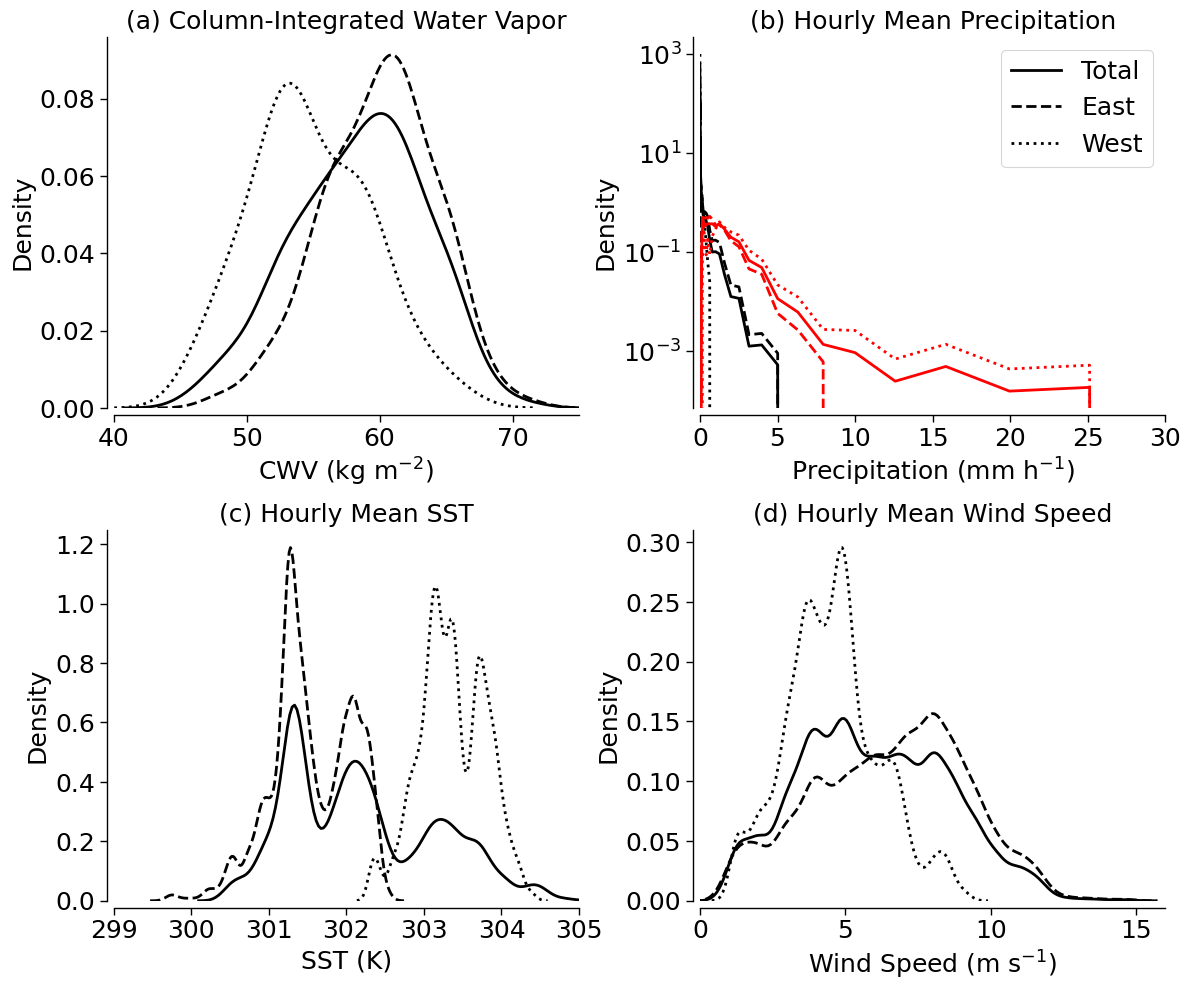

In [30]:
fig, axs = plt.subplots(2,2,figsize=(12,10))

sns.kdeplot(cwv_finite, ax=axs[0,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(cwvE_finite, ax=axs[0,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(cwvW_finite, ax=axs[0,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,0].set_title('(a) Column-Integrated Water Vapor',fontsize=18)
axs[0,0].set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0,0].set_ylabel('Density',fontsize=18)
axs[0,0].set_xlim(40,75)
#axs[0,0].legend(fontsize=18)
axs[0,0].tick_params(labelsize=18)

#pbins = np.concatenate((np.arange(0,1,0.1),np.arange(1,5,1),np.arange(5,50,5),np.arange(50,250,100)))
pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.1))))
phist1, bin_edges1 = np.histogram(precip2, bins=pbins, density=True)
phist2, bin_edges2 = np.histogram(precipE2, bins=pbins, density=True)
phist3, bin_edges3 = np.histogram(precipW2, bins=pbins, density=True)

phist1a, bin_edges1a = np.histogram(precip2int, bins=pbins, density=True)
phist2a, bin_edges2a = np.histogram(precipE2int, bins=pbins, density=True)
phist3a, bin_edges3a = np.histogram(precipW2int, bins=pbins, density=True)

axs[0,1].plot(bin_edges1[:-1], phist1, color='black', label='Total', linewidth=2)
axs[0,1].plot(bin_edges2[:-1], phist2, color='black', linestyle='--', label='East', linewidth=2)
axs[0,1].plot(bin_edges3[:-1], phist3, color='black', linestyle=':', label='West', linewidth=2)

axs[0,1].plot(bin_edges1a[:-1], phist1a, color='red', linewidth=2)
axs[0,1].plot(bin_edges2a[:-1], phist2a, color='red', linestyle='--', linewidth=2)
axs[0,1].plot(bin_edges3a[:-1], phist3a, color='red', linestyle=':', linewidth=2)

#sns.kdeplot(precip, ax=axs[0,1],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
#sns.kdeplot(precipE, ax=axs[0,1],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
#sns.kdeplot(precipW, ax=axs[0,1],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,1].set_title('(b) Hourly Mean Precipitation',fontsize=18)
axs[0,1].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[0,1].set_ylabel('Density',fontsize=18)
axs[0,1].set_xlim(0,30)
#axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].legend(fontsize=18)
axs[0,1].tick_params(labelsize=18)

sns.kdeplot(sst_smoothed2, ax=axs[1,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(sst_smoothedE2, ax=axs[1,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(sst_smoothedW2, ax=axs[1,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

#sns.kdeplot(sst_smoothed2, ax=axs[1,0],label='Sea Snake',fill=False,common_norm=False,color='red',linewidth=2)
#sns.kdeplot(sst_smoothedE2, ax=axs[1,0],label='East',fill=False,common_norm=False,color='red',linestyle='--',linewidth=2)
#sns.kdeplot(sst_smoothedW2, ax=axs[1,0],label='West',fill=False,common_norm=False,color='red',linestyle=':',linewidth=2)

axs[1,0].set_title('(c) Hourly Mean SST',fontsize=18)
axs[1,0].set_xlabel('SST (K)',fontsize=18)
axs[1,0].set_ylabel('Density',fontsize=18)
axs[1,0].set_xlim(299,305)
#axs[1,0].legend(fontsize=14)
axs[1,0].tick_params(labelsize=18)

sns.kdeplot(wspd_smoothed, ax=axs[1,1],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(wspd_smoothedE, ax=axs[1,1],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(wspd_smoothedW, ax=axs[1,1],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[1,1].set_title('(d) Hourly Mean Wind Speed',fontsize=18)
axs[1,1].set_xlabel('Wind Speed (m s$^{-1}$)',fontsize=18)
axs[1,1].set_ylabel('Density',fontsize=18)
#axs[1,1].legend(fontsize=18)
axs[1,1].set_xlim(0,16)
axs[1,1].tick_params(labelsize=18)


sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
#plt.savefig('../../figures/Fig_pdf_EW.png')
